# Classical pipeline

In [1]:
import torch
from lambeq.training import Dataset, PytorchModel, PytorchTrainer

SEED = 0

### Input data

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append(torch.as_tensor([t, 1-t]))
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [3]:
import warnings
warnings.filterwarnings("ignore")

from lambeq.ccg2discocat import DepCCGParser

reader = DepCCGParser(possible_root_cats=['S[dcl]'])

train_diagrams = reader.sentences2diagrams(train_data)
dev_diagrams = reader.sentences2diagrams(dev_data)
test_diagrams = reader.sentences2diagrams(test_data)

### Create circuits

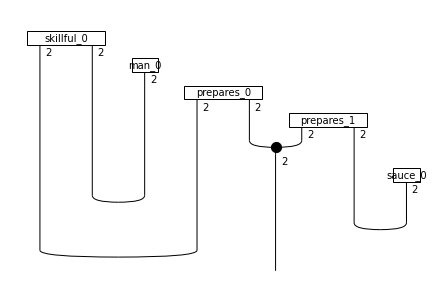

In [4]:
from discopy import Dim

from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

### Parameterise

In [5]:
all_circuits = train_circuits + dev_circuits + test_circuits
model = PytorchModel(all_circuits, seed=SEED)

### Define Evaluation Metric

In [6]:
def accuracy(preds, targets):
    hits = 0
    for i in range(len(preds)):
        target = targets[i]
        pred = preds[i]
        if torch.argmax(target) == torch.argmax(pred):
            hits += 1
    return hits / len(preds)

### Initialize Trainer

In [7]:
BATCH_SIZE = 30
EPOCHS = 20
LEARNING_RATE = 3e-2

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,    # type: ignore
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions={"acc": accuracy},
        verbose=False)

In [8]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE,
            seed=SEED)

dev_dataset = Dataset(dev_circuits, dev_labels)

### Train

In [9]:
trainer.fit(train_dataset, dev_dataset)

....................................................................................................
Training successful!


### Show results

Test accuracy: 1.0


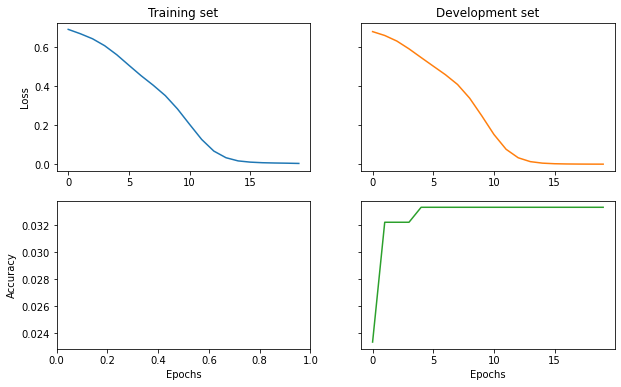

In [10]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model.forward(test_circuits), test_labels)
print('Test accuracy:', test_acc)